# Data Visualisation of COVID-19 in the UK using Sqlite, Pandas and Seaborn Libraries 
## Part 3: Visualise the Data

This notebook explores the UK Gov's COVID-19 dashboard data.  

The dashboard data is made up of several tables which consist of different metrics (such as positive cases, deaths and hospital admissions) broken down at different geographical levels - some metrics are available at lower or upper tier local authority (LTLA/UTLA), some at Region and NHS Region and some nationally or overall within the UK.  We will explore several of these tables to produce queries and visualisations of various metrics at different geography levels.  

The data used in this notebook is publically available and more information can be found here:
https://coronavirus.data.gov.uk/details/about-data

### Configuration and Setup

We also import the Seaborn and Plotly express libraries for use in data visualisation.

In [86]:
import seaborn as sns
import plotly.express as px
import sqlite3
import pandas as pd

sqlite_db_path = "c19.db"

### Optional: Uncompress Sqlite database file 

If you compressed the database in the previous notebook, then you'll need to first decompress the file before opening it.

In [87]:
import os
import gzip
import shutil

with gzip.open(sqlite_db_path + '.gz', 'rb') as f_in:
    with open(sqlite_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

### Open the database connection

In [88]:
conn = sqlite3.connect('c19.db', detect_types=sqlite3.PARSE_DECLTYPES)

### Querying Basics: England Positive Cases by Date

Let's start of with a simple example.  We're going to get all the positive test cases that occurred in England from the start of the Covid pandemic, and plot these against the published date.

In [89]:
df = pd.read_sql(
    """
        SELECT date, new_cases_by_publish_date
        FROM c19dashboard_uk__national_daily_metrics
        WHERE area_name = 'England'
        ORDER BY date    
    """,
    conn
)

df.tail()

,date,new_cases_by_publish_date
574,2021-08-26,29417.0
575,2021-08-27,27545.0
576,2021-08-28,25118.0
577,2021-08-29,22501.0
578,2021-08-30,21324.0


Pretty simple query - select the date and positive cases, filter this by England (since this table contains other UK nations), and then order by the date field.  Let's generate a line plot and see how this looks ...

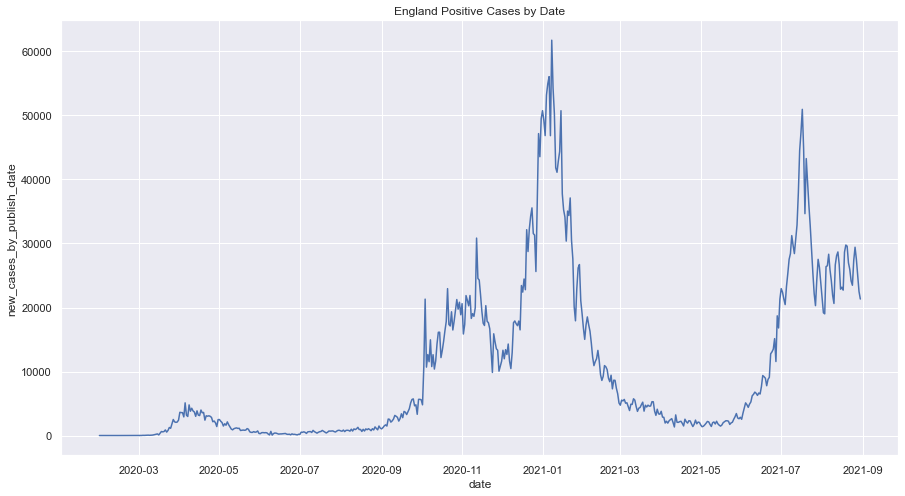

In [90]:
sns.set(rc={'figure.figsize':(15,8)})
g = sns.lineplot(data=df, x="date", y="new_cases_by_publish_date").set(title="England Positive Cases by Date")

### Introducing Windowed functions and CTEs

Hmmmm, OK - so this looks OK but it's not a smooth line.  This is probably due to the nature of reporting during the week when lower numbers are recorded at the weekend.  So let's fix that and generate a 7 day moving average - to do this we use an aggregated Window function as shown below - it generates a SUM of new cases over the last 7 days (current row = 0).  

``` mysql
SUM(new_cases_by_publish_date) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW)
```

But let's also modify the query to show us the last 365 days.  Now we could use a hard-coded date filter, but that means everytime you run the query, you need to change the values.  So let's generate a derived field (```num_days_ago```) and we can filter on this.  Again we use window function which is ordered by date - but this time in descending order, and we simply generate a sequential value:

``` mysql
ROW_NUMBER() OVER (ORDER BY date DESC)
```

So one more thing we need to do.  If we want to filter by a Window functioned value that we've derived, we essentially need to somehow alias it with a new column name, and then filter in a separate expression.  We do this using a Common Table Expression (CTE) using the ```WITH``` statement.

``` mysql
;WITH cte AS (
    ...
)
SELECT * FROM cte
```

Now let's put all this in action and try to plot the data again.

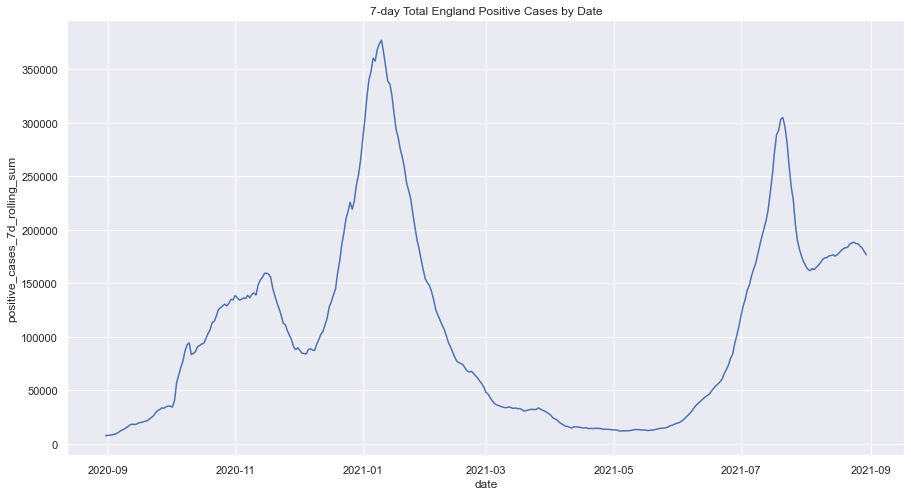

In [91]:
df = pd.read_sql(
    """
    ;WITH england_cases AS (
        SELECT 
            date, 
            SUM(new_cases_by_publish_date) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS positive_cases_7d_rolling_sum,
            ROW_NUMBER() OVER (ORDER BY date DESC) AS num_days_ago
        FROM c19dashboard_uk__national_daily_metrics
        WHERE area_name = 'England'
    )
    SELECT
        date,
        positive_cases_7d_rolling_sum
    FROM england_cases
    WHERE num_days_ago <= 365
    """,
    conn
)

sns.set(rc={'figure.figsize':(15,8)})
g = sns.lineplot(data=df, x="date", y="positive_cases_7d_rolling_sum").set(title="7-day Total England Positive Cases by Date")

That's much better.  We'll use the CTEs and Window functions in the following queries.  Let's move on to a slightly more complex query.

### Query Table Joins: 7-day average deaths per 1 Million Population broken down by Region

We want to look at deaths by region.  Again we use a window function to produce a 7 day rolling average to smooth out lower reported deaths at the weekend.  However, different regions have different populations so to compare we want to standardise the average deaths by the region's population.

For this we'll look at the ```reference_populations_2019__lsoa_msoa_ltla_utla_region_by_age``` table which provides populations by age (and all ages) at LSOA geographical area.  In order to get population by region, we need to be able to map LSOAs to Regions and we can do this using the ```reference_geography__lsoa_msoa_ltla_utla_region_mappings``` table.

So we join the two tables and simply SUM the ```all_ages``` population to get regional populations like this:

```mysql
    SELECT
        lsoa_to_rgn.rgn_name,
        SUM(pop_lsoa.all_ages) AS total_population   
    FROM 
        reference_populations_2019__lsoa_msoa_ltla_utla_region_by_age pop_lsoa
        INNER JOIN reference_geography__lsoa_msoa_ltla_utla_region_mappings lsoa_to_rgn
            ON pop_lsoa.code = lsoa_to_rgn.lsoa_code
    GROUP BY     
        lsoa_to_rgn.rgn_name
```

We can then apply this to what we did previously using CTEs, Window functions (for the 7 day average death) to get the breakdown we need.  For this we'll limit the timescales to the last 90 days. 

However, because we're now introducing an extra level of aggregation (in this case Region), then we need to apply that extra level of breakdown to the Windowed function calls and we do this using the ```PARTITION BY``` keyword.   For example, generating a sequential number for the date (```num_days_ago```) which is the same sequence for each region, we can do the following:

```mysql 
ROW_NUMBER() OVER (PARTITION BY area_name ORDER BY date DESC)
```

In [92]:
df = pd.read_sql(
    """
    ;WITH all_populations AS (
        SELECT 
            area_code,
            population
        FROM reference_geography__age_gender_populations
        WHERE category = 'ALL'
    ), region_7d_deaths AS (
        SELECT
            area_code AS region_code,
            area_name AS region_name,
            date AS publish_date,
            AVG(1.0 * new_deaths_28_days_by_death_date) OVER (PARTITION BY area_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS deaths_7d_rolling_avg,
            ROW_NUMBER() OVER (PARTITION BY area_name ORDER BY date DESC) AS num_days_ago
        FROM c19dashboard_uk__region_daily_metrics
    )
    SELECT 
        rgn.publish_date,
        rgn.region_name,
        (rgn.deaths_7d_rolling_avg * 1000000.0)/pop.population AS deaths_7d_avg_per_1M_population  
    FROM 
        region_7d_deaths rgn
        INNER JOIN all_populations pop
            ON rgn.region_code = pop.area_code
    WHERE 
        rgn.num_days_ago <= 90
    ORDER BY
        rgn.publish_date,
        rgn.region_name    
    """,
    conn
)

df.head()

,publish_date,region_name,deaths_7d_avg_per_1M_population
0,2021-06-02,East Midlands,0.058721
1,2021-06-02,East of England,0.159511
2,2021-06-02,London,0.063475
3,2021-06-02,North East,0.106579
4,2021-06-02,North West,0.271464


Let's plot how the death rates vary by region over the last 90 days

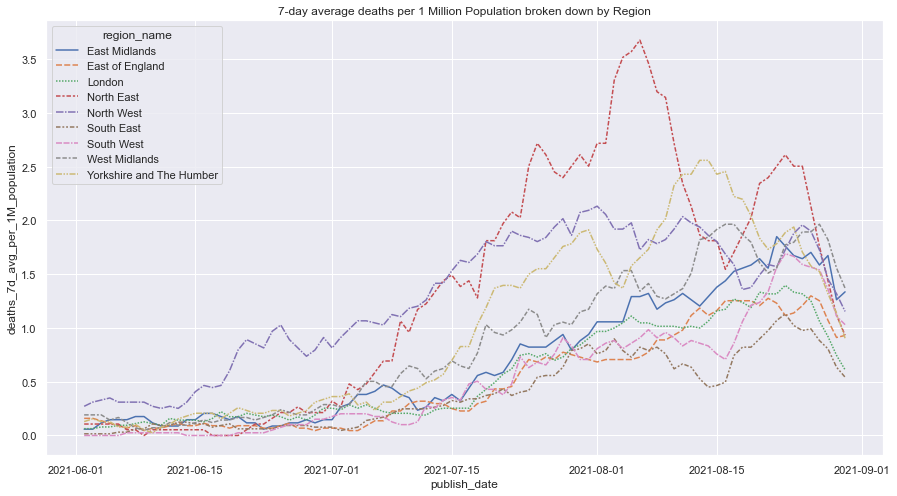

In [93]:
sns.set(rc={'figure.figsize':(15,8)})
g = sns.lineplot(data=df, x="publish_date", y="deaths_7d_avg_per_1M_population", hue="region_name", style="region_name").set(title="7-day average deaths per 1 Million Population broken down by Region")

### England 7-day rolling sum positive cases by Age Group and Gender (over last 60 days)

Let's do a slightly different breakdown - this time positive cases by Age Group and Gender.  The ```c19dashboard_uk__national_cases_by_age_gender``` table provides cases by different age groups and genders.

Again we use a window function to produce a 7 day rolling sum to smooth out lower reported cases at the weekend and we'll filter the dates to only show the last 60 days.

We can then use Seaborn's ```relplot``` function to provide line charts in a grid (faceted) - so the X, Y axis is similar to before: cases by date, but now a separate graph is generated per age group providing a rapid way to visualise the data.  In addition we use the colour (hue) parameter to provide male and female lines on the same graph.

Because each graph's X axis is small, using the actual date looks cluttered and unreadable.  So for this example, we use the ```strftime``` function to convert the date to a single number (week of the year) which looks better on the graphs.

Note that the 0-4 and 5-9 age groups need to be converted to include a leading 0 digit so that the ordering of graphs is in the correct age order.


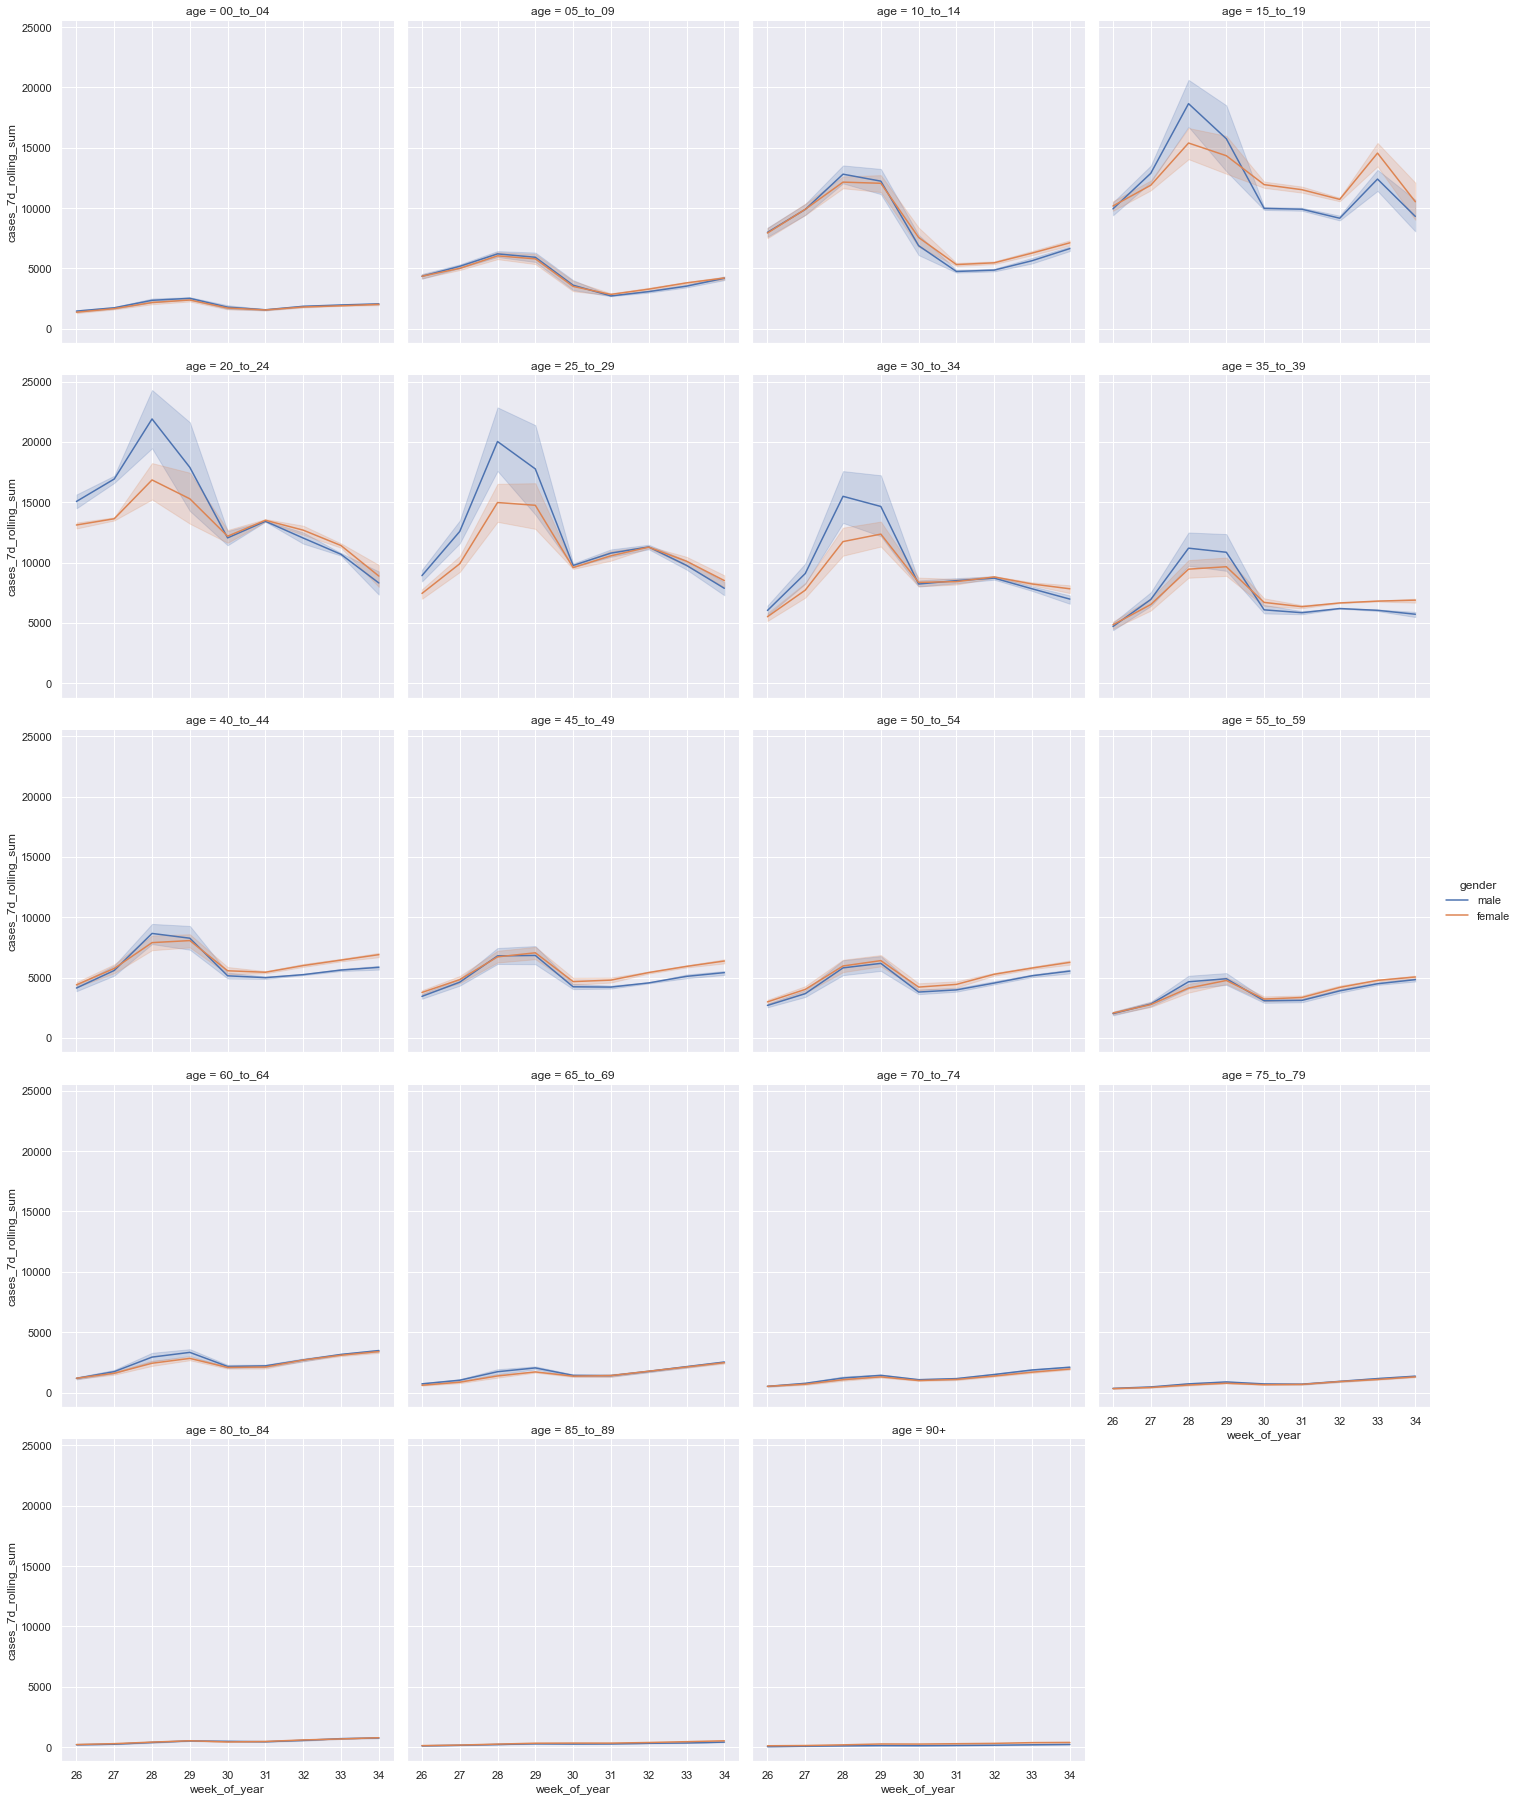

In [94]:
df = pd.read_sql(
    """
    ;WITH cases_by_age AS (
        SELECT
            strftime('%W', date) AS week_of_year,
            gender,
            CASE 
                WHEN age = '0_to_4' THEN '00_to_04'
                WHEN age = '5_to_9' THEN '05_to_09'
                ELSE age END AS age,
            SUM(new_cases) OVER (PARTITION BY gender, age ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS cases_7d_rolling_sum,
            ROW_NUMBER() OVER (PARTITION BY gender, age ORDER BY date DESC) AS num_days_ago
        FROM c19dashboard_uk__national_cases_by_age_gender
        WHERE area_name = 'England'
    )
    SELECT
        week_of_year,
        gender,
        age,
        cases_7d_rolling_sum
    FROM cases_by_age
    WHERE
        num_days_ago <= 60
    ORDER BY
        gender,
        age,
        week_of_year
    """,
    conn
)

g = sns.relplot(
    data=df, x="week_of_year", y="cases_7d_rolling_sum", 
    col="age", hue="gender", hue_order=["male","female"], 
    col_wrap=4, kind="line"
)

### Latest 7-day Positive Cases and Deaths by Region-UTLA hierarchy

In this example we'll use a Plotly Treemap which is interactive and let's us drilldown from Region to UTLA level.  We visualise the positive cases by size, and deaths by colour.

First we'll need the number of cases/deaths at UTLA level which we can find in the ```c19dashboard_uk__utla_daily_metrics``` table.  Additionally we'll take a similar approach in the previous example to get population by UTLA, as well as generating a mapping between UTLA and Region using the ```reference_geography__lsoa_msoa_ltla_utla_region_mappings``` table.

We only ever want the latest figures (based on the latest 7 day window), so we filter the results by the latest date using a sub-query which looks like this:

```mysql
WHERE date = (SELECT MAX(date) FROM c19dashboard_uk__utla_daily_metrics)
```

The following query give us what we need:  Region, UTLA, Positive Cases (7-day rolling sum per 100,000 population) and Deaths (7-day rolling average per 1 million population).

In [95]:
df = pd.read_sql(
    """
    ;WITH utla_to_region AS (
        SELECT DISTINCT 
            utla_code,
            region_name
        FROM reference_geography__ltla_utla_region_mappings   
    ), utla_populations AS (    
        SELECT 
            area_code,
            population
        FROM reference_geography__age_gender_populations
        WHERE category = 'ALL'
    ), utla_metrics AS (
        SELECT
            utla.date,
            utla.area_code AS utla_code,
            utla.area_name AS utla_name,
            utla_to_rgn.region_name,
            SUM(1.0 * utla.new_cases_by_publish_date) OVER (PARTITION BY utla.area_code ORDER BY utla.date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS positive_cases_7d_rolling_sum,
            AVG(1.0 * utla.new_deaths_28_days_by_publish_date) OVER (PARTITION BY utla.area_code ORDER BY utla.date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS deaths_7d_rolling_avg
        FROM 
            c19dashboard_uk__utla_daily_metrics utla
            INNER JOIN utla_to_region utla_to_rgn
                ON utla.area_code = utla_to_rgn.utla_code    
    )
    SELECT
        utla.region_name,
        utla.utla_name,
        CAST((utla.positive_cases_7d_rolling_sum * 100000.0)/pop.population AS INT) AS positive_cases_7d_sum_per_100K_population,
        CAST((utla.deaths_7d_rolling_avg * 1000000.0)/pop.population AS REAL) AS deaths_7d_avg_per_1M_population
    FROM 
        utla_metrics utla
        INNER JOIN utla_populations pop
            ON utla.utla_code = pop.area_code
    WHERE utla.date = (SELECT MAX(date) FROM utla_metrics)
    ORDER BY positive_cases_7d_sum_per_100K_population DESC
    """, 
    conn
)

# Since we've used an ORDER BY, the following will show the Top 10 UTLAs for Positive Cases
df.head(10)

,region_name,utla_name,positive_cases_7d_sum_per_100K_population,deaths_7d_avg_per_1M_population
0,South West,Plymouth,517,3.804610
1,Yorkshire and The Humber,"Kingston upon Hull, City of",514,1.102608
2,South West,Cornwall and Isles of Scilly,511,2.233985
3,Wales,Swansea,481,NaN
4,East of England,Peterborough,480,2.115086
5,South West,Torbay,472,9.438652
6,North West,Blackpool,466,4.129386
7,South East,Portsmouth,463,0.665405
8,Yorkshire and The Humber,Rotherham,418,4.312929
9,North West,Knowsley,413,1.874126


#### Using the Plotly Express Treemap

To create the treemap, we use Plotly Express.  Using the path parameter we can setup the hierachy between Region and UTLA, and then specify what the treemap size is based on and what the colours are based on.  Once the chart is generated, you can zoom in and out of specific regions.  Note that Wales doesn't have values for the deaths metric so there is no colour codes.

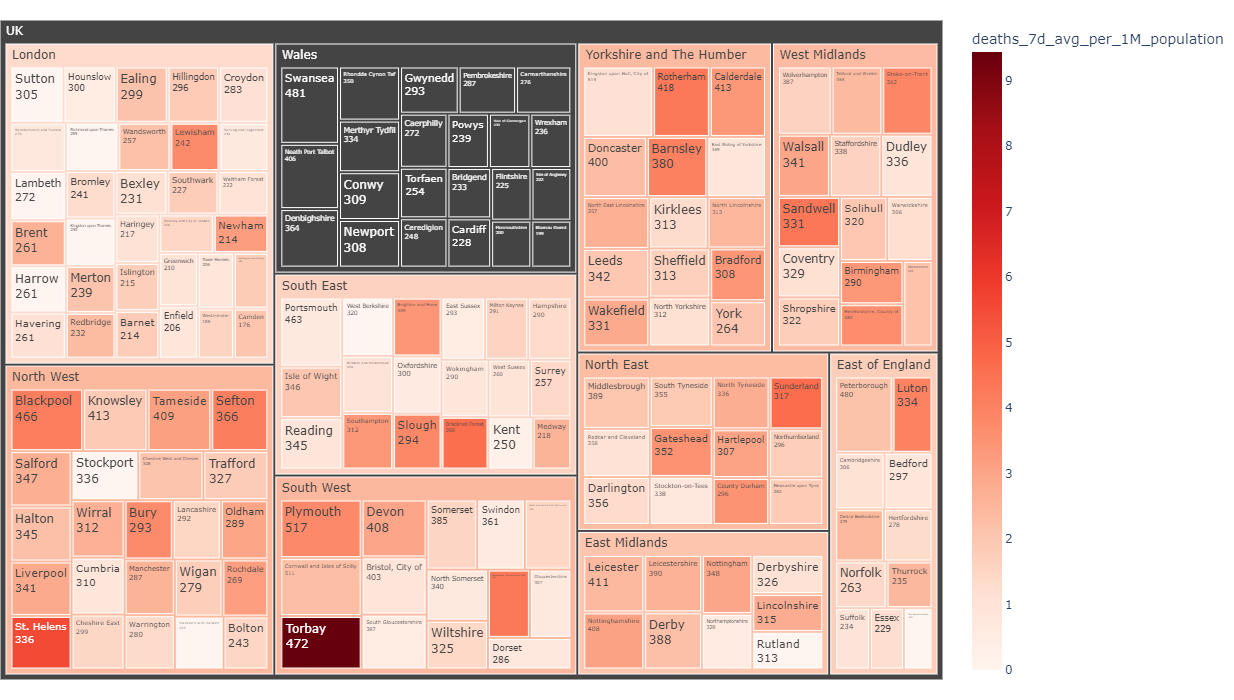

In [96]:
fig = px.treemap(df, path=[px.Constant("UK"),'region_name', 'utla_name'], values='positive_cases_7d_sum_per_100K_population',
                  color='deaths_7d_avg_per_1M_population',
                  color_continuous_scale='reds')
fig.data[0].textinfo = 'label+text+value'
fig.update_layout(margin = dict(t=20, l=0, r=0, b=20), autosize=False,width=1200,height=700)
fig.show()

### Digging Deeper: Latest 30-day time-series of Top 5 UTLAs by Positive Cases for all Regions

Let's go further.  This time we shall produce the latest 30-day time-series for all Regions.  Each of these charts will show the top 5 UTLAs for the region in terms of 7-day rolling sum per 100,000 population positive COVID-19 cases.

There's nothing really new in this example, apart from the complexity.  To make this easier to manage, we break the full query down into a set of common table expressions (CTEs).  Essentially we need to perform 2 separate rankings.  One set of rankings is used to generate the top 5 UTLAs and we do this based on the latest date.  The other is ranked by date so we can filter out only the latest 30 days.  We then join these together.  It's pretty easy to modify the query below to change the timescale (to more or less than 30 days) as well as how much UTLAs are included in each region's rankings.

Finally we use Seaborn's ```relplot``` to produce a 3 column grid of time-series plots, one for each region.  Note the x labels become illegible because of the size of the graphs so we rotate these to make them clearer to read.

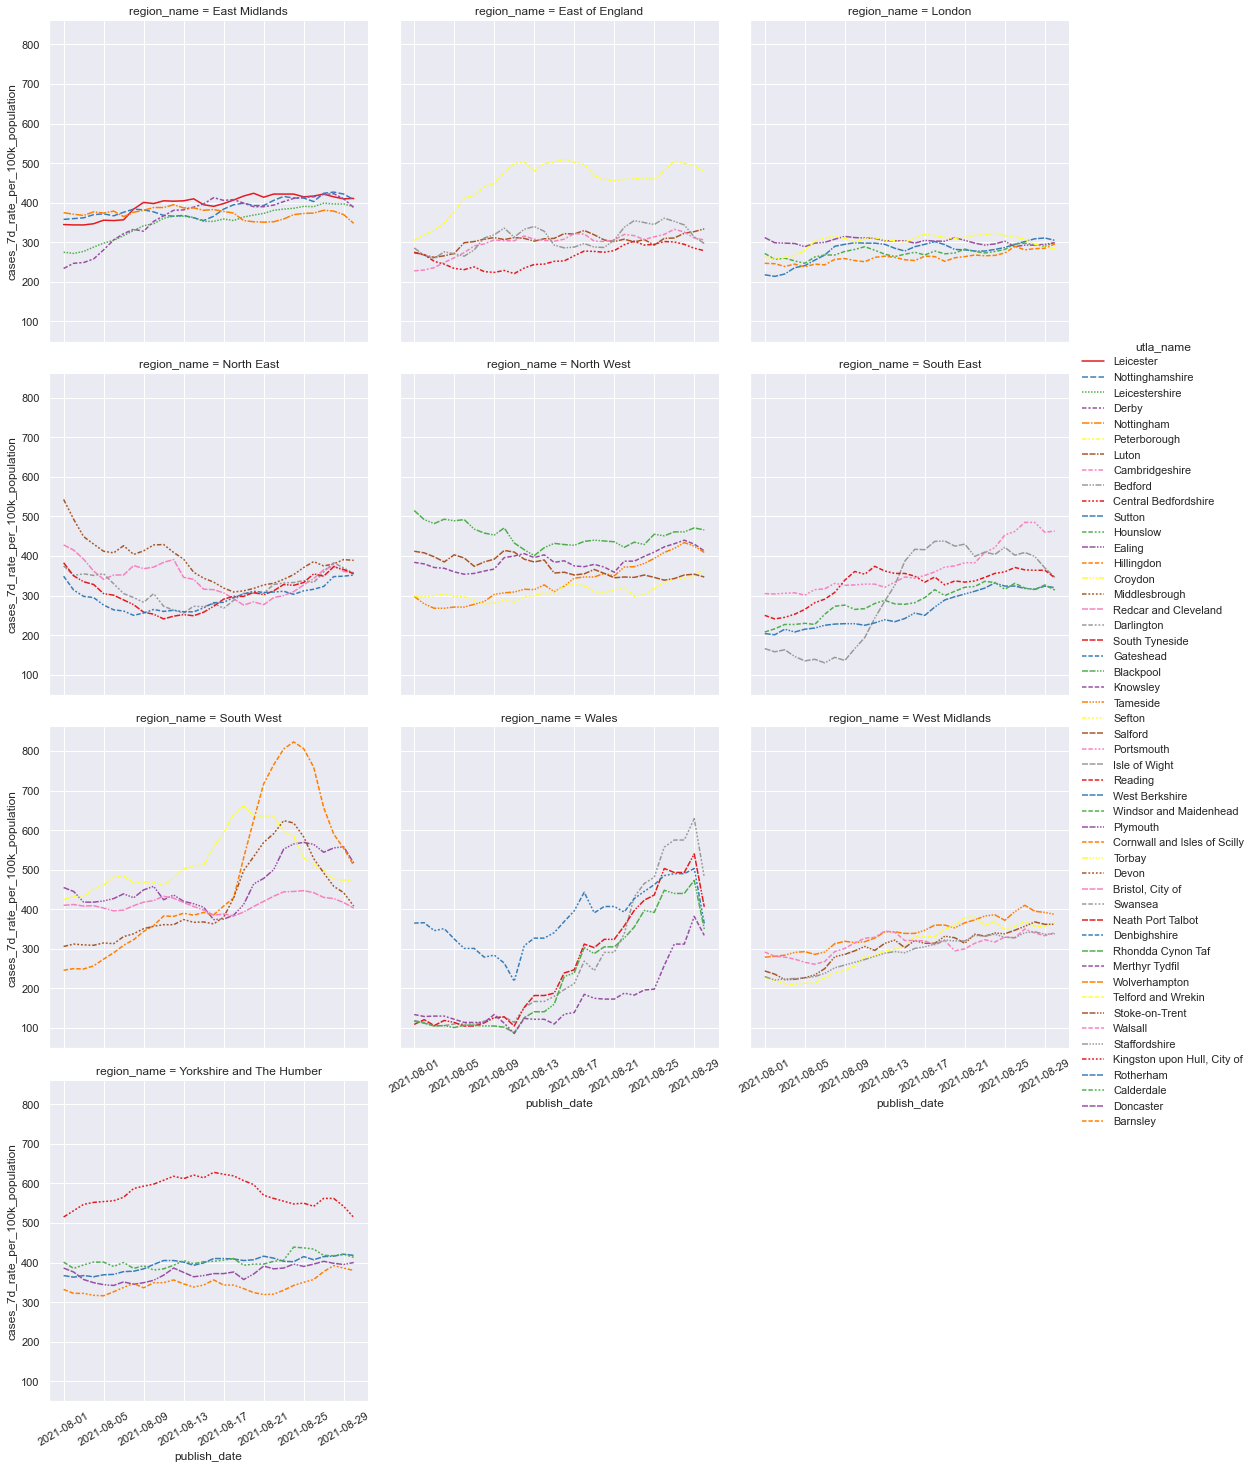

In [97]:
df = pd.read_sql(
    """
    
    ;WITH utla_to_region AS (
        SELECT DISTINCT 
            utla_code,
            region_name
        FROM reference_geography__ltla_utla_region_mappings   
    ), populations_by_utla AS (    
        SELECT 
            utla_to_rgn.region_name,
            utla_to_rgn.utla_code,
            pop.population AS total_population
        FROM 
            reference_geography__age_gender_populations pop
            INNER JOIN utla_to_region utla_to_rgn
                ON pop.area_code = utla_to_rgn.utla_code
        WHERE pop.category = 'ALL'
    ), pos_7d_cases_by_utla_and_date AS (
        SELECT
            area_code AS utla_code,
            area_name AS utla_name,
            date AS publish_date,
            SUM(1.0 * new_cases_by_publish_date) OVER (PARTITION BY area_code ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS positive_cases_7d_rolling_sum
        FROM c19dashboard_uk__utla_daily_metrics
    ), pos_7d_cases_per_pop_by_utla_and_date AS (
        SELECT
            pop.region_name,
            utla.utla_code,
            utla.utla_name,
            utla.publish_date,
            CAST((utla.positive_cases_7d_rolling_sum * 100000.0)/pop.total_population AS INTEGER) AS cases_7d_rate_per_100k_population
        FROM 
            pos_7d_cases_by_utla_and_date utla
            INNER JOIN populations_by_utla pop
                ON utla.utla_code = pop.utla_code
    ), pos_7d_cases_per_pop_by_utla_and_date_with_date_rank AS (
        SELECT
            region_name,
            utla_code,
            utla_name,
            publish_date,
            cases_7d_rate_per_100k_population,
            ROW_NUMBER() OVER (PARTITION BY utla_code ORDER BY publish_date DESC) AS num_days_ago
        FROM pos_7d_cases_per_pop_by_utla_and_date 
    ), pos_7d_cases_per_pop_by_utla_and_date_with_case_rank AS (
        SELECT
            region_name,
            utla_code,
            utla_name,
            publish_date,
            ROW_NUMBER() OVER (PARTITION BY region_name ORDER BY cases_7d_rate_per_100k_population DESC) AS positive_cases_7d_rolling_sum_rank
        FROM pos_7d_cases_per_pop_by_utla_and_date 
        WHERE 
            publish_date = (SELECT MAX(publish_date) FROM pos_7d_cases_per_pop_by_utla_and_date)
    )
    SELECT
        r1.region_name,
        r1.utla_name,
        r1.publish_date,
        r1.cases_7d_rate_per_100k_population
    FROM 
        pos_7d_cases_per_pop_by_utla_and_date_with_date_rank r1
        INNER JOIN pos_7d_cases_per_pop_by_utla_and_date_with_case_rank r2
            ON r1.utla_code = r2.utla_code
    WHERE
        r1.num_days_ago <= 30
    AND r2.positive_cases_7d_rolling_sum_rank <= 5
    ORDER BY
            r1.region_name,
            r2.positive_cases_7d_rolling_sum_rank,
            r1.publish_date
    """, 
    conn
)

g = sns.relplot(
    data=df, x="publish_date", y="cases_7d_rate_per_100k_population", 
    hue="utla_name", style="utla_name", col="region_name", 
    col_wrap=3, kind="line", palette="Set1"
)

# rotate x labels so they're legible
tx = g.set_xticklabels(rotation=30)

### Hospital Metrics over the last 60 days by NHS Region

So far we've looked at positive cases and deaths.  Now we explore some hospital metrics: number of admissions, number of patients in hospital and patients on mechanical ventilation.

This data is available at NHS Region level using the ```c19dashboard_uk__nhsregion_daily_metrics``` table.

In order to use Seaborn's ```relplot``` function we need to move away from wide format data.  This refers to the three metrics as being three separate columns.  In order to plot multiple series, we need to convert to long format - that is one row per metric.

This is pretty straightforward using SQL - we simply have a ```SELECT``` statement for each metric and use ```UNION ALL``` to stitch them together into one output.  We have one column to define which metric (```metric_type```), and one column for the metric's value (```metric_value```).  We can then pass these to the ```relplot``` function to have have a time-series with all 3 metrics.  We then produce separate charts for each of the NHS Regions.

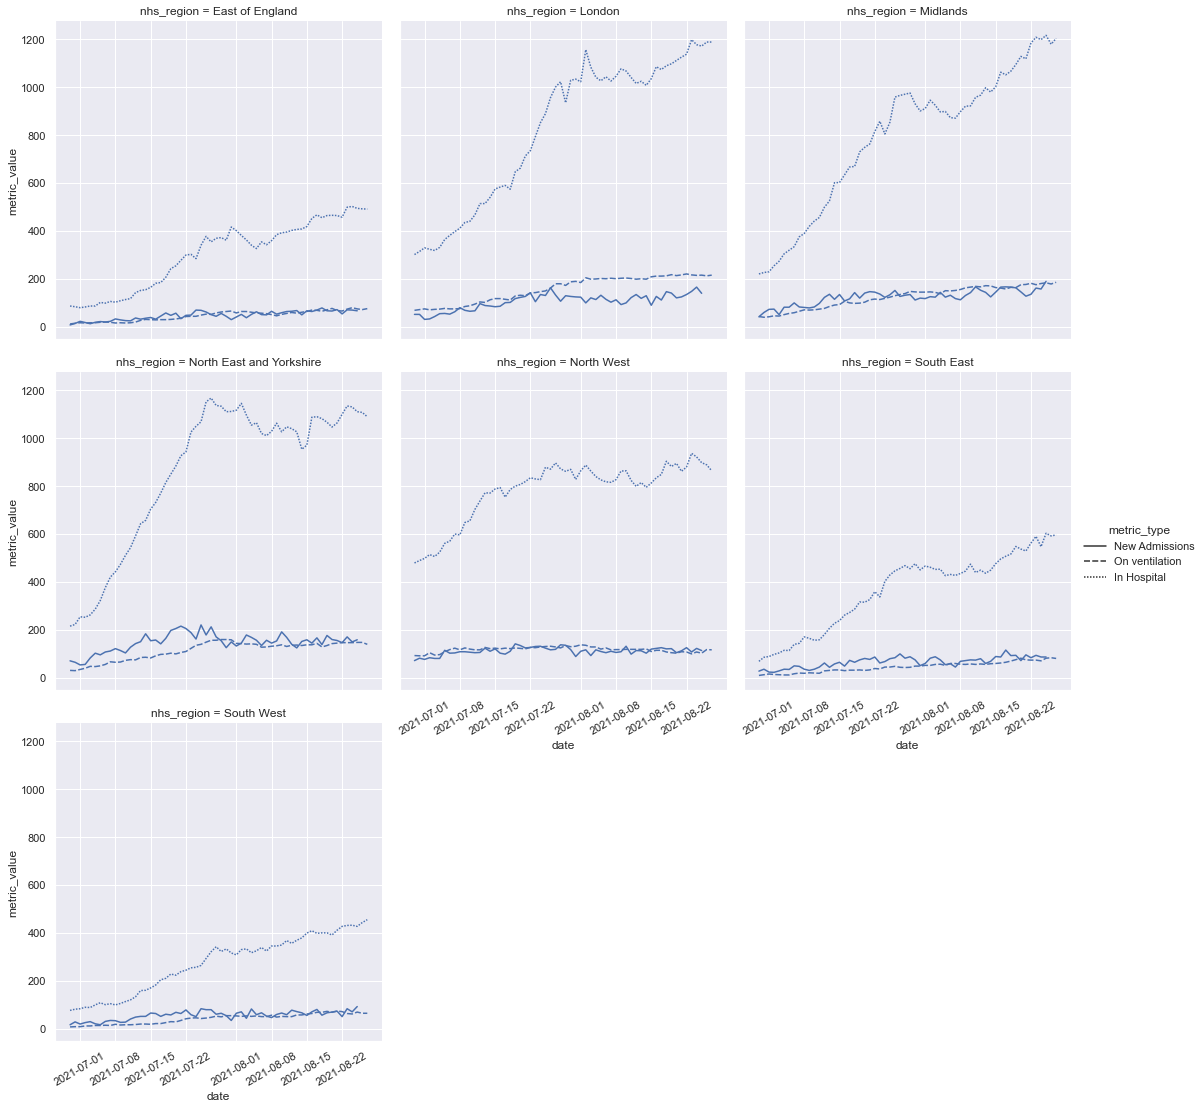

In [98]:
df = pd.read_sql(
    """
    ;WITH nhs_region_metrics_wide_format AS (
        SELECT
            area_name AS nhs_region,
            date,
            new_admissions,
            covid_occupied_mv_beds,
            hospital_cases,
            ROW_NUMBER() OVER (PARTITION BY area_name ORDER BY date DESC) AS num_days_ago
        FROM c19dashboard_uk__nhsregion_daily_metrics
    ), nhs_region_metrics AS (
        SELECT nhs_region, date, num_days_ago, new_admissions AS metric_value, 'New Admissions' AS metric_type
        FROM nhs_region_metrics_wide_format
            UNION ALL
        SELECT nhs_region, date, num_days_ago, covid_occupied_mv_beds AS metric_value, 'On ventilation' AS metric_type
        FROM nhs_region_metrics_wide_format
            UNION ALL
        SELECT nhs_region, date, num_days_ago, hospital_cases AS metric_value, 'In Hospital' AS metric_type
        FROM nhs_region_metrics_wide_format
    )
    SELECT 
        nhs_region, 
        date, 
        metric_value, 
        metric_type
    FROM nhs_region_metrics
    WHERE num_days_ago <= 60
    """, 
    conn
)

g = sns.relplot(
    data=df, x="date", y="metric_value", 
    col="nhs_region", style="metric_type",
    col_wrap=3, kind="line", palette="Set1"
)

# rotate x labels so they're legible
tx = g.set_xticklabels(rotation=30)

### England 7-day average Cases, Deaths, Vaccinations and Hospital Metrics over the last 120 days 

Similar to the previous example, we can show separate plots for each of the metrics available at England level using the ```c19dashboard_uk__national_daily_metrics``` table.

Again we convert the wide format data into long format using the same ```UNION ALL``` technique as we did last time.

One difference this time is that we really need the separate plots to have a separate Y-axis scale, so for this we use the ```facet_kws``` parameter and specify that the Y-axis is not shared.

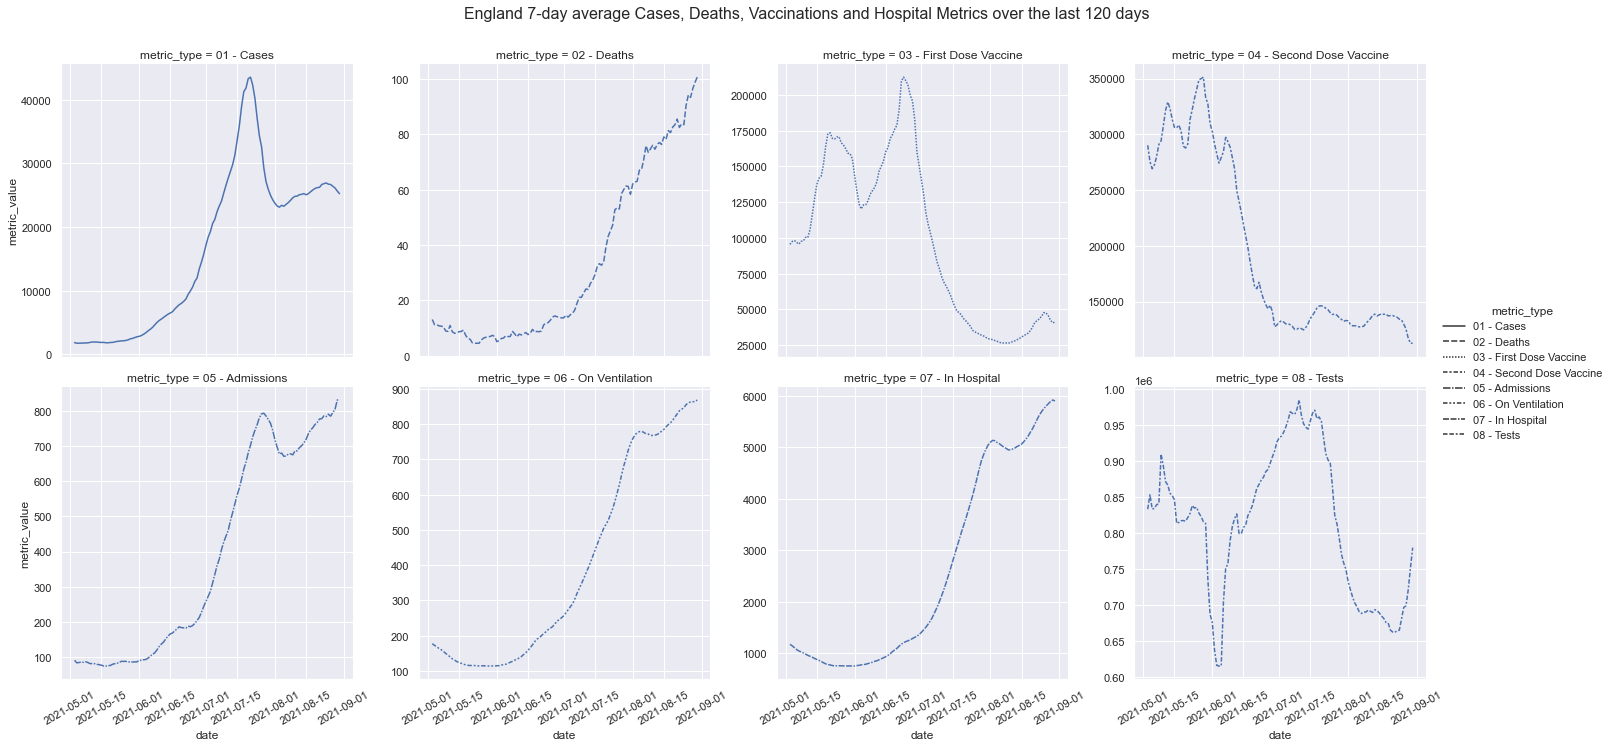

In [99]:
df = pd.read_sql(
    """
    ;WITH england_metrics AS (
        SELECT
            date,
            new_cases_by_publish_date,
            new_admissions,
            covid_occupied_mv_beds,
            hospital_cases,
            new_deaths_28_days_by_publish_date,
            new_tests_by_publish_date,
            new_people_vaccinated_first_dose_by_publish_date,
            new_people_vaccinated_second_dose_by_publish_date,
            ROW_NUMBER() OVER (ORDER BY date DESC) AS num_days_ago    
        FROM 
            c19dashboard_uk__national_daily_metrics
        WHERE 
            area_name = 'England'
    ), england_metrics_7d_avg AS (
        SELECT
            date,
            AVG(new_cases_by_publish_date) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS cases_7d_avg,
            AVG(new_admissions) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS admissions_7d_avg,
            AVG(covid_occupied_mv_beds) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS on_ventilators_7d_avg,
            AVG(hospital_cases) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS in_hospital_7d_avg,
            AVG(new_deaths_28_days_by_publish_date) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS deaths_7d_avg,
            AVG(new_tests_by_publish_date) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS tests_7d_avg,
            AVG(new_people_vaccinated_first_dose_by_publish_date) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS first_dose_7d_avg,
            AVG(new_people_vaccinated_second_dose_by_publish_date) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS second_dose_7d_avg,
            ROW_NUMBER() OVER (ORDER BY date DESC) AS num_days_ago    
        FROM 
            england_metrics
    ), england_metrics_pivot AS (
            SELECT date, num_days_ago, cases_7d_avg AS metric_value, '01 - Cases' AS metric_type
            FROM england_metrics_7d_avg
                UNION ALL
            SELECT date, num_days_ago, deaths_7d_avg AS metric_value, '02 - Deaths' AS metric_type
            FROM england_metrics_7d_avg
                UNION ALL
            SELECT date, num_days_ago, first_dose_7d_avg AS metric_value, '03 - First Dose Vaccine' AS metric_type
            FROM england_metrics_7d_avg    
                UNION ALL
            SELECT date, num_days_ago, second_dose_7d_avg AS metric_value, '04 - Second Dose Vaccine' AS metric_type
            FROM england_metrics_7d_avg                 
                UNION ALL
            SELECT date, num_days_ago, admissions_7d_avg AS metric_value, '05 - Admissions' AS metric_type
            FROM england_metrics_7d_avg
                UNION ALL
            SELECT date, num_days_ago, on_ventilators_7d_avg AS metric_value, '06 - On Ventilation' AS metric_type
            FROM england_metrics_7d_avg
                UNION ALL
            SELECT date, num_days_ago, in_hospital_7d_avg AS metric_value, '07 - In Hospital' AS metric_type
            FROM england_metrics_7d_avg            
                UNION ALL
            SELECT date, num_days_ago, tests_7d_avg AS metric_value, '08 - Tests' AS metric_type
            FROM england_metrics_7d_avg
    )    
    SELECT 
        date, 
        metric_value, 
        metric_type
    FROM england_metrics_pivot
    WHERE num_days_ago <= 120
    ORDER BY
        metric_type,
        date
    """, 
    conn
)

g = sns.relplot(
    data=df, x="date", y="metric_value", 
    col="metric_type", style="metric_type", kind="line", palette="Set1", col_wrap=4,
    facet_kws={'sharey': False, 'sharex': True}
)
g.fig.suptitle('England 7-day average Cases, Deaths, Vaccinations and Hospital Metrics over the last 120 days', fontsize=16)
g.fig.subplots_adjust(top=0.9);

# rotate x labels so they're legible
tx = g.set_xticklabels(rotation=30)

### Generating a COVID-19 Vaccination Uptake Chart with PyWaffle 

On the UK Gov's Coronavirus dashboard, the percentage uptake of vaccination (first and second dose) is shown as a *waffle* chart.  We can do the same thing using matplotlib but we need to install the PyWaffle library and then import it ready for use as follows.

In [ ]:
import sys
!{sys.executable} -m pip install PyWaffle
import matplotlib.pyplot as plt
from pywaffle import Waffle

Using the ```c19dashboard_uk__national_daily_metrics```  table we need to get the total first and second dose uptake and then divide this by an estimate of the UK's 16+ population to get a percentage.

First we take just the latest data using ```MAX(date)``` and then we sum the totals since these are broken down by nation and we need a UK total.  Then we need pivot the results in order to get a Pandas data series that can be used by the PyWaffle graphing component.  Note that sometimes the latest data doesn't contain the cumulative totals so we filter based on the maximum date where these two fields have data.

Since the first dose is really shown as a delta on the second dose, then we actually subtract the second dose total from the first for the purposes of this chart, and finally get the percentage that haven't taken the vaccine.

In [101]:
df = pd.read_sql(
"""
;WITH vaccination_totals AS (
    SELECT
        SUM(cum_people_vaccinated_first_dose_by_publish_date) AS total_first_dose, 
        SUM(cum_people_vaccinated_second_dose_by_publish_date) AS total_second_dose 
    FROM c19dashboard_uk__national_daily_metrics 
    WHERE
        date = (
            SELECT MAX(date) 
            FROM c19dashboard_uk__national_daily_metrics
            WHERE
                cum_people_vaccinated_first_dose_by_publish_date IS NOT NULL
            AND cum_people_vaccinated_second_dose_by_publish_date IS NOT NULL
        )
)
SELECT
    'Second Dose' AS dose,
    total_second_dose/543268.0 AS percentage_uptake
FROM vaccination_totals 
    UNION ALL
SELECT
    'First Dose' AS dose,
    (total_first_dose - total_second_dose)/543268.0 AS percentage_uptake
FROM vaccination_totals 
    
    UNION ALL
SELECT
    'None' AS dose,
    (54326800 - total_first_dose)/543268.0 AS percentage_uptake
FROM vaccination_totals 
    
--ORDER BY percentage_uptake DESC
""", 
    conn
)
df.head()

,dose,percentage_uptake
0,Second Dose,78.632741
1,First Dose,9.767327
2,None,11.599932


Now we configure the Waffle chart and pass in the ```percentage_uptake``` series as the data.

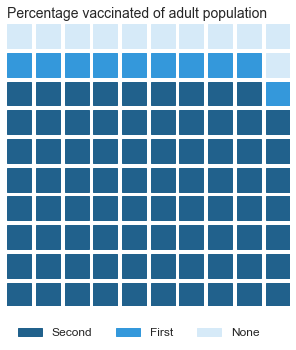

In [102]:
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(
    FigureClass=Waffle,
    rows=10, columns=10, vertical=True, rounding_rule='nearest',
    values=df["percentage_uptake"],
    title={'label': 'Percentage vaccinated of adult population','loc': 'left','fontdict': {'fontsize': 14}},    
    legend={'labels': ["Second","First","None"],'loc': 'lower left','bbox_to_anchor': (0, -0.15),'ncol': 3,'framealpha': 0,'fontsize': 12},
    colors=["#21618C", "#3498DB", "#D6EAF8"],
    figsize=(10, 5)
)
fig.show()

### Cleanup

Ensure all changes are committed and then close the Sqlite connection.  Also force garbage collection - at this point, there should be no locks on the database file so it could be zipped up and deleted.

In [103]:
import gc

# Commit and close Sqlite connection
conn.commit()
conn.close()

# Force garbage collection
_ = gc.collect(2)

### Optional: Compress Sqlite database file 

To help keep file sizes small and to allow the database to be easily stored in a Git repo, you may want to compress the database file and then remove the original.

In [104]:
import os
import gzip
import shutil

with open(sqlite_db_path, "rb") as f_in:
    with gzip.open(sqlite_db_path + ".gz", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
        
os.remove(sqlite_db_path)